# Initial

In [0]:
!pip -q install --upgrade --ignore-installed numpy pandas scipy sklearn

In [0]:
!pip -q install catboost
!pip -q install lightgbm

In [0]:
!pip -q install "dask[complete]"
!pip -q install "dask-ml[complete]"

In [0]:
# https://stackoverflow.com/questions/49853303/how-to-install-pydot-graphviz-on-google-colab?rq=1
!pip -q install graphviz 
!apt-get install graphviz -qq
!pip -q install pydot

In [0]:
# After this restart your kernel using Ctrl+M+. to reset all loaded libraries to latest ones, that we just installed.

# Import

In [0]:
import pandas as pd
import numpy as np
from multiprocessing import Pool
from pandas.io.json import json_normalize
from sklearn.pipeline import make_pipeline, Pipeline
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler
from threading import Thread as trd
import queue
import json
import gc
gc.enable()

# Initial 2

In [0]:
from sklearn.datasets import fetch_california_housing

In [3]:
dictionary = fetch_california_housing()

In [4]:
dictionary.keys()

dict_keys(['data', 'target', 'feature_names', 'DESCR'])

In [5]:
dictionary.data.shape

(20640, 8)

In [0]:
xtrain = pd.DataFrame(dictionary.data, index=np.arange(len(dictionary.data)), columns=dictionary.feature_names)
xtrain['Target'] = dictionary.target

In [0]:
new_ = xtrain.iloc[:,:2].to_dict('list')
new_row = []
for i in range(len(xtrain)):
  dic_ = {}
  for key in new_.keys():
    dic_[key] = new_[key][i]
  new_row.append(str(dic_))

In [0]:
xtrain['Dict'] = new_row

In [9]:
xtrain.head(2)

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,Target,Dict
0,8.3252,41.0,6.984127,1.02381,322.0,2.555556,37.88,-122.23,4.526,"{'MedInc': 8.3252, 'HouseAge': 41.0}"
1,8.3014,21.0,6.238137,0.97188,2401.0,2.109842,37.86,-122.22,3.585,"{'MedInc': 8.3014, 'HouseAge': 21.0}"


In [0]:
for i in range(6):
  xtrain = pd.concat([xtrain, xtrain], axis=0, sort=False).reset_index(drop=True)

In [11]:
xtrain.shape

(1320960, 10)

In [0]:
xtrain.reset_index().to_csv("train.csv", index=False)

In [13]:
del xtrain, dictionary, new_row, new_, dic_
gc.collect()

143

# Incremental Learning

### Data Exploration:

In [0]:
!ls

In [0]:
part = pd.read_csv("train.csv", nrows=10)
part.shape

(10, 11)

In [0]:
columns = part.columns
part.head(2)

,index,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,Target,Dict
0,0,8.3252,41.0,6.984127,1.02381,322.0,2.555556,37.88,-122.23,4.526,"{'MedInc': 8.3252, 'HouseAge': 41.0}"
1,1,8.3014,21.0,6.238137,0.97188,2401.0,2.109842,37.86,-122.22,3.585,"{'MedInc': 8.3014, 'HouseAge': 21.0}"


In [0]:
# From above output you will have a basic understanding of type of columns. Divide them so you
# can use same function on similar columns (for exploration etc).
id_columns = ["index"]
num_columns = ["MedInc", "HouseAge", "AveRooms", "AveBedrms", "Population", "AveOccup", "Latitude", "Longitude", "Target"]
obj_columns = []
dict_columns = ["Dict"]
complex_columns = []

In [0]:
index_col = "index"
columns_visited = ["MedInc", "HouseAge", "AveRooms"]

In [0]:
col = "Dict"
df = pd.read_csv("train.csv.zip", usecols = [10])

df[col] = df[col].map(lambda x: json.loads(x.replace("'", '"')))

column_as_df = json_normalize(df[col])
column_as_df.head()

,HouseAge,MedInc
0,41.0,8.3252
1,21.0,8.3014
2,52.0,7.2574
3,52.0,5.6431
4,52.0,3.8462


In [0]:
# Explore this column. Check if you want to keep it or not.
# If you want to scale this column or LableEncode this column, 
# do it and maintain a dictionary with all columns as keys and
# corresponding Scalar or LabelEncoder or both as values.

In [0]:
# Calculate Standard Deviation, check if they are constant...
column_as_df.std()

HouseAge    12.585257
MedInc       1.899776
dtype: float64

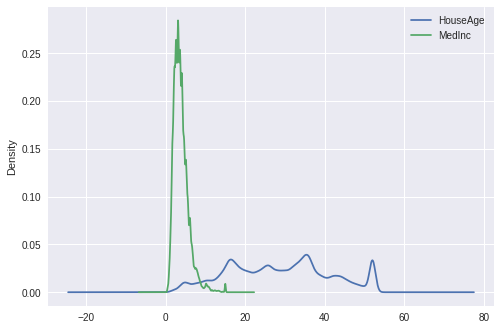

In [0]:
column_as_df.plot.kde()

In [0]:
columns_selected = ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude', 'Target']

In [0]:
preprocessing_pipeline = {col: [] for col in columns_selected}

In [0]:
# Here I am doing all at once. But you can do it column by column.
data = pd.read_csv("train.csv")
for col_ in columns_selected:
  rsc = RobustScaler()
  rsc.fit(data[col_].values.reshape(-1, 1)) # You have to do this for RobustScaler...
  preprocessing_pipeline[col_].append(rsc)

In [0]:
import pickle
with open("pipeline.pickle", "wb") as fle:
  pickle.dump(preprocessing_pipeline, fle)
!ls

**Note:**

If even one column of dataset is larger than your memory, then you can open that column incrementally (by using `chunksize` parameter in `pd.read_csv`), applying some transformation (maybe keeping it in a `np.float32` if its a number or maybe keeping only relevant part of a string and throwing all other away.)

But if that column is not fitting into your memory, you can use `Dask`. (see last section)

### Preprocessing method:

In [0]:
# After opening dictionary columns these will change, you can change it to reflect that.
id_columns = []
num_columns = ["MedInc", "HouseAge", "AveRooms", "AveBedrms", "Population", "AveOccup", "Latitude", "Longitude", "Target"]
obj_columns = []
dict_columns = []
complex_columns = []

In [0]:
columns_to_drop_completely = ["index", "Dict"]

In [0]:
# Now that you have a dictionary which has all the columns you need as keys
# and corresponding methods you want to apply to that column sequentially,
# you can make a preprocesing method which will be used to clean data at
# every incremental step.

def preprocess(df):
  df.reset_index(drop=True, inplace=True)
  df = df.drop(columns_to_drop_completely, axis=1)
  
  # For dict columns:
  for col in dict_columns:
    if col not in df.columns: pass
    col_df = json_normalize(df[col])                                            # You are already doing json.loads during pd.read_csv to convert string to dict
    col_df.columns = [f"{col}.{subcolumn}" for subcolumn in col_df.columns]
    selected_columns = [c for c in dictionary.keys() if c in col_df.columns()]  # Select all columns from this dict-column which we selected before
    to_drop = [c for c in col_df.columns if c not in selected_columns]
    col_df = col_df.drop(to_drop, axis=1)                                       # Drop all previously unselected sub-columns from this dict_column
    
    df = df.drop([col], axis=1).merge(col_df, right_index=True, left_index=True)
    
  # And so on...
  
  # And then apply all Scalars, LabelEncoders to all columns selected...
  for col_ in columns_selected:
    # RobustScaler at position 0
    rsc = preprocessing_pipeline[col_][0]
    df[col_] = rsc.transform(df[col_].values.reshape(-1, 1)).reshape(1, -1)[0] # Because of RobustScaler
  
  return df

**Note:**

One thing to notice here is that we fitted methods (like LabelEncoder's, Scalars's etc.) during exploration to **whole** data column and we will use that to transform data at every incremental step here. Because, in each batch, there might be some data missing and if we had used different LabelEncoder's, Scaler's etc. for each batch, these methods wouldn't have given same result for same category (say). That's why to be on safe side, we already have fitted to whole columns during exploration.

### Method 1: Using Pandas

In [0]:
import lightgbm as lgb
import xgboost as xgb
import catboost as cb # CatBoost is currently making its incremental learner: https://github.com/catboost/catboost/issues/464
from sklearn.model_selection import train_test_split

In [0]:
incremental_dataframe = pd.read_csv("train.csv.zip", chunksize=100000) # Number of lines to read.
# This method will return a kind of sequential file reader reading 'chunksize' lines every time.
# To read file from starting again, you will have to call this method again.

In [0]:
lgb_params = {
  'objective': 'regression',
  'verbosity': 0,
}
# First three are necessary for incremental learning.
xgb_params = {
  'update':'refresh',
  'process_type': 'update',
  'refresh_leaf': True,
  'silent': True,
  }

For intro on Parallel programming in Python read my post [here](https://towardsdatascience.com/speed-up-your-algorithms-part-3-parallelization-4d95c0888748).

In [0]:
# For saving regressor for next use.
lgb_estimator = None
xgb_estimator = None

for df in incremental_dataframe:
  df = preprocess(df)
  
  xtrain, xvalid, ytrain,  yvalid = train_test_split(df.drop(['Target'], axis=1), df['Target'] )

  lgb_estimator = lgb.train(lgb_params,
                         init_model=lgb_estimator, # Pass partially trained model
                         train_set=lgb.Dataset(xtrain, ytrain),
                         valid_sets=[lgb.Dataset(xvalid, yvalid)],
                         valid_names=["Valid"],
                         early_stopping_rounds = 50,
                         keep_training_booster=True, # For incremental learning
                         num_boost_round=70,
                         verbose_eval=50) # Output after each of 50th times
  
  #xgb_model = xgb.train(xgb_params, dtrain=(xtrain, ytrain),
  #                      evals = (xgb.DMatrix(x_tr, y_tr), "Valid"),
  #                      xgb_model = xgb_estimator) # Pass partially trained model
  
  del df, xtrain, ytrain, xvalid, yvalid
  gc.collect()

Training until validation scores don't improve for 50 rounds.
[50]	Valid's l2: 0.0963618
Did not meet early stopping. Best iteration is:
[70]	Valid's l2: 0.0864367
Training until validation scores don't improve for 50 rounds.
[100]	Valid's l2: 0.0743662
Did not meet early stopping. Best iteration is:
[140]	Valid's l2: 0.0663257
Training until validation scores don't improve for 50 rounds.
[150]	Valid's l2: 0.0630322
[200]	Valid's l2: 0.0560808
Did not meet early stopping. Best iteration is:
[210]	Valid's l2: 0.054903
Training until validation scores don't improve for 50 rounds.
[250]	Valid's l2: 0.0475982
Did not meet early stopping. Best iteration is:
[280]	Valid's l2: 0.0452189
Training until validation scores don't improve for 50 rounds.
[300]	Valid's l2: 0.0434777
[350]	Valid's l2: 0.0399569
Did not meet early stopping. Best iteration is:
[350]	Valid's l2: 0.0399569
Training until validation scores don't improve for 50 rounds.
[400]	Valid's l2: 0.0358432
Did not meet early stopping

In [0]:
test = pd.read_csv("train.csv", nrows = 10000)

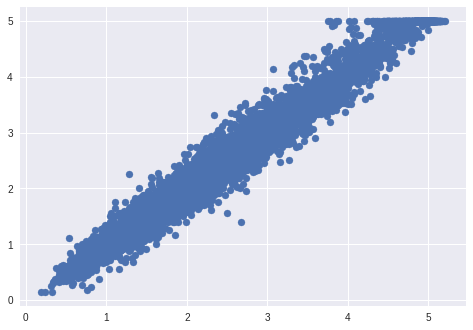

In [0]:
preds = lgb_estimator.predict(preprocess(test).drop(['Target'], axis=1))
preds = preprocessing_pipeline['Target'][0].inverse_transform(preds.reshape(-1, 1)).reshape(1, -1)[0]
true = test['Target']
plt.scatter(preds, true)

# Method 2: Using Dask:



For intro on Dask read my post [here](https://towardsdatascience.com/speeding-up-your-algorithms-part-4-dask-7c6ed79994ef).

**Note:**
You should only use `Dask` in case of Big Data, where it is not able to fit in your memory.

In [0]:
import dask

In [15]:
import dask.dataframe as dd
from dask.distributed import Client
client = Client(processes=False, threads_per_worker=4, n_workers=4, memory_limit='8GB')
client

Client Scheduler: inproc://172.28.0.2/805/1,Cluster Workers: 4 Cores: 16 Memory: 32.00 GB


In [0]:
df = dd.read_csv("train.csv", blocksize=25e6)

In [17]:
df.npartitions

8

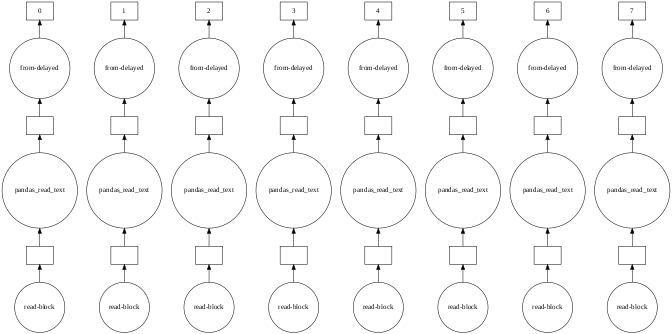

In [18]:
df.visualize(size="7,5!")

In [19]:
df.head()

,index,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,Target,Dict
0,0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526,"{'MedInc': 8.3252, 'HouseAge': 41.0}"
1,1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585,"{'MedInc': 8.3014, 'HouseAge': 21.0}"
2,2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521,"{'MedInc': 7.2574, 'HouseAge': 52.0}"
3,3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413,"{'MedInc': 5.6431, 'HouseAge': 52.0}"
4,4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422,"{'MedInc': 3.8462, 'HouseAge': 52.0}"


**NOTE:**

`Dask` doesn't have equivalent fucntion of `pandas`'s `json_normalize`. But we can use `Dask`'s `to_bag` function and `bag`'s capability to handle JSON to our advantage.

This method is taken from a great kernel by [Misha Lisovyi](https://www.kaggle.com/mlisovyi), [here](https://www.kaggle.com/mlisovyi/bigdata-dask-pandas-flat-json-trim-data-upd), on Kaggle.

In [0]:
# Convert string Series to dictionary Series
df['Dict'] = df['Dict'].apply(lambda x: json.loads(x.replace("'", '"')), meta=('Dict', 'f8'))

In [0]:
dict_col_keys = {
    'Dict': ['MedInc', 'HouseAge']
}

In [0]:
for dic_col in dict_col_keys:
  for key in dict_col_keys[dic_col]:
    df[f'{dic_col}.{key}'] = df[dic_col].to_bag().pluck(key).to_dataframe().iloc[:,0]

In [23]:
df.head()

,index,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,Target,Dict,Dict.MedInc,Dict.HouseAge
0,0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526,"{'MedInc': 8.3252, 'HouseAge': 41.0}",8.3252,41.0
1,1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585,"{'MedInc': 8.3014, 'HouseAge': 21.0}",8.3014,21.0
2,2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521,"{'MedInc': 7.2574, 'HouseAge': 52.0}",7.2574,52.0
3,3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413,"{'MedInc': 5.6431, 'HouseAge': 52.0}",5.6431,52.0
4,4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422,"{'MedInc': 3.8462, 'HouseAge': 52.0}",3.8462,52.0


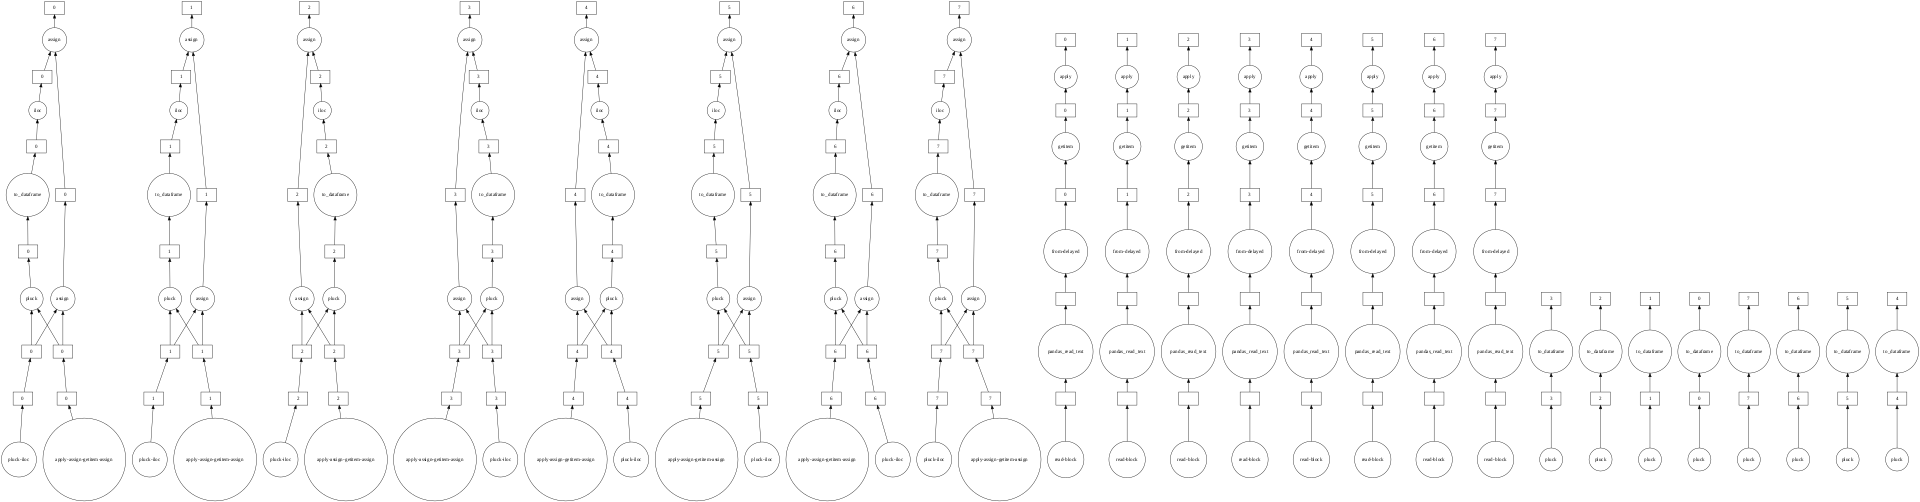

In [24]:
df.visualize(size="20,10!")

In [0]:
columns_to_drop = ['index', 'Dict', 'Dict.MedInc', 'Dict.HouseAge']

In [0]:
df = df.drop(columns_to_drop, axis=1)

In [27]:
df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,Target
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [28]:
df.isnull().sum().compute()

MedInc        0
HouseAge      0
AveRooms      0
AveBedrms     0
Population    0
AveOccup      0
Latitude      0
Longitude     0
Target        0
dtype: int64

You cannot re-input scaled values from your dataframe directly into its columns (It has to be a series). So, we will Scale Array and directly use it to train our model.

In [29]:
# Necessary for converting dataframe to array. Takes specified length from each block.
lengths = []
for part in df.partitions:
  l = part.shape[0].compute()
  lengths.append(l)
  print(l, part.shape[1])

182557 9
181760 9
181750 9
181756 9
181750 9
181087 9
180446 9
49854 9


In [0]:
X, y = df.drop(['Target'], axis=1).to_dask_array(lengths=lengths) , df['Target'].to_dask_array(lengths=lengths)

In [0]:
Xo = dask.array.zeros((X.shape[0],1), chunks=(200000,1))
from dask_ml.preprocessing import RobustScaler
for i, col_ in enumerate(df.columns):
  if col_ == "Target":
    rsc = RobustScaler()
    y = rsc.fit_transform(y.reshape(-1, 1)).reshape(1, -1)[0]
  else:
    rsc = RobustScaler()
    temp = rsc.fit_transform(X[:,i].reshape(-1, 1))
    Xo = dask.array.concatenate([Xo, temp], axis=1)

In [0]:
Xo = Xo[:, 1:]

In [144]:
Xo[-5:].compute()

array([[-9.11033660e-01, -2.10526316e-01, -1.32135031e-01,
         8.99459515e-01, -3.45010616e-01, -3.05382018e-01,
         1.32631579e+00, -7.09677419e-01],
       [-4.54049344e-01, -5.78947368e-01,  5.33792434e-01,
         2.84432167e+00, -8.64118896e-01,  3.53090353e-01,
         1.32894737e+00, -7.41935484e-01],
       [-8.46968724e-01, -6.31578947e-01, -3.23698645e-02,
         7.58319669e-01, -1.73036093e-01, -5.80589452e-01,
         1.31315789e+00, -7.44623656e-01],
       [-7.70292580e-01, -5.78947368e-01,  4.48869608e-02,
         1.31076550e+00, -4.55414013e-01, -8.17678848e-01,
         1.31315789e+00, -7.71505376e-01],
       [-5.31184078e-01, -6.84210526e-01, -1.72501711e-03,
         1.20784296e+00,  2.30360934e-01, -2.39353267e-01,
         1.29736842e+00, -7.50000000e-01]])

To make blocks for both of equal size. Otherwise you might get broadcast error.



In [0]:
Xo = Xo.rechunk({1: Xo.shape[1]})
Xo = Xo.rechunk({0: 200000})
y = y.rechunk({0: 200000})

In [179]:
tr_len = 0.8*Xo.shape[0]
xtrain, ytrain = Xo[:tr_len], y[:tr_len]
xvalid, yvalid = Xo[tr_len:], y[tr_len:]
xtrain.shape, ytrain.shape, xvalid.shape, yvalid.shape

((1056768, 8), (1056768,), (264192, 8), (264192,))

In [0]:
from dask_ml.linear_model import LinearRegression

In [0]:
est = LinearRegression()

In [182]:
est.fit(xtrain, y=ytrain)

LinearRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
         intercept_scaling=1.0, max_iter=100, multiclass='ovr', n_jobs=1,
         penalty='l2', random_state=None, solver='admm',
         solver_kwargs=None, tol=0.0001, verbose=0, warm_start=False)

In [0]:
preds = est.predict(xvalid)

In [184]:
preds[0:10].compute()

array([ 0.35169143,  0.46621322,  0.41237802,  0.28285737,  0.24595807,
        0.08746062,  0.24150728,  0.26845929, -0.11211374,  0.40954053])

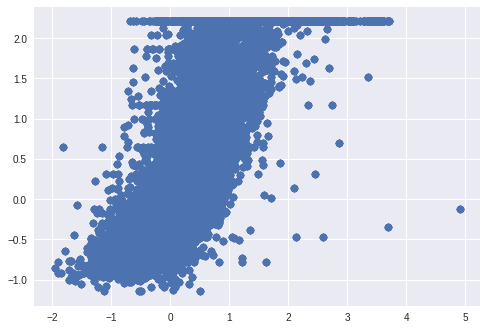

In [185]:
plt.scatter(preds.compute(), yvalid.compute())